In this notebook we do a quick analysis of the baseline and train/test set splits.

In [20]:
# General imports
import numpy as np
import torch

# DeepMoD stuff
from deepymod_torch import DeepMoD
from deepymod_torch.model.func_approx import Siren
from deepymod_torch.model.library import Library1D
from deepymod_torch.model.constraint import LeastSquares
from deepymod_torch.model.sparse_estimators import Clustering, Threshold
from deepymod_torch.training import train
from deepymod_torch.training.sparsity_scheduler import Periodic

from phimal_utilities.data import Dataset
from phimal_utilities.data.kdv import DoubleSoliton

from phimal_utilities.analysis import load_tensorboard, Results
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

if torch.cuda.is_available():
    device ='cuda'
else:
    device = 'cpu'

# Settings for reproducibility
np.random.seed(42)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Baseline

We first get the noiselevel of the dataset:

In [2]:
# Making data
v = 0.1
A = 1.0
x = np.linspace(-5, 5, 100)
t = np.linspace(0.0, 1.0, 50)

x_grid, t_grid = np.meshgrid(x, t, indexing='ij')
dataset = Dataset(DoubleSoliton, c=[5.0, 2.0], x0=[-3.0, -1.0])
X_train, y_train = dataset.create_dataset(x_grid.reshape(-1, 1), t_grid.reshape(-1, 1), n_samples=500, noise=0.0, normalize=True, random=True)

In [5]:
min_MSE = (0.2 * np.std(y_train.numpy()))**2
print(min_MSE)

0.015791406869368675


In [48]:
df_baseline = Results('data/baseline/')

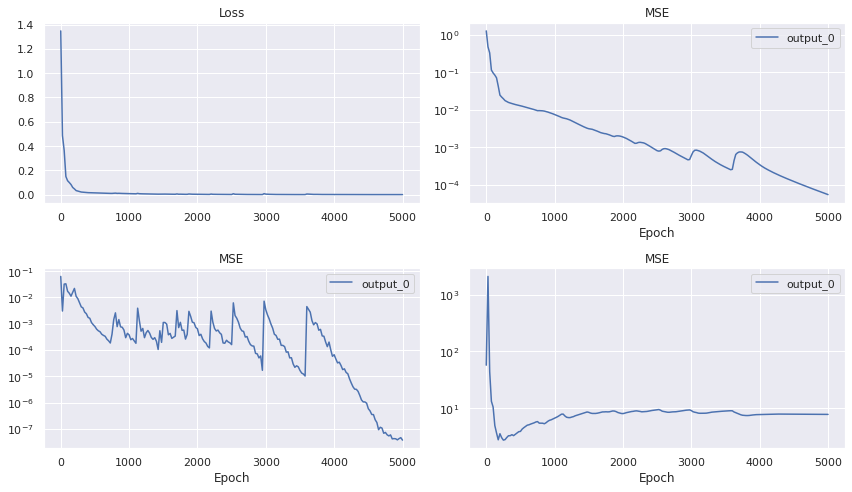

In [49]:
df_baseline.plot_losses()

We're especially interested in the MSE:

Text(0.5, 1.0, 'MSE')

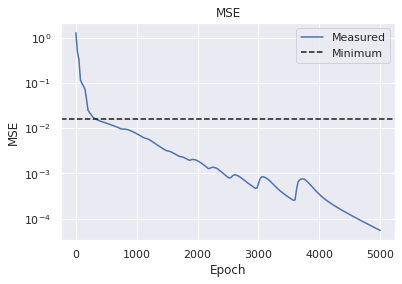

In [50]:
plt.semilogy(df_baseline.df[df_baseline.keys['mse']], label='Measured')
plt.axhline(min_MSE, color='k', linestyle='--', label='Minimum')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('MSE')

Where is the cross over?

In [51]:
df_baseline.df.index[np.argmax(df_baseline.df[df_baseline.keys['mse']] < min_MSE)]

350

Let's check out the coefficients just before this point:

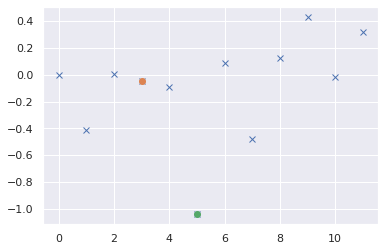

In [52]:
plt.plot(np.arange(12), df_baseline.df[df_baseline.keys['coeffs']].loc[300], 'x')
plt.plot(3, df_baseline.df[df_baseline.keys['coeffs'][3]].loc[300], 'o')
plt.plot(5, df_baseline.df[df_baseline.keys['coeffs'][5]].loc[300], 'o')

Which is not great, maybe doing L1 would've made it better? Let's change the code so we also always write the l1 adjusted coefficients!

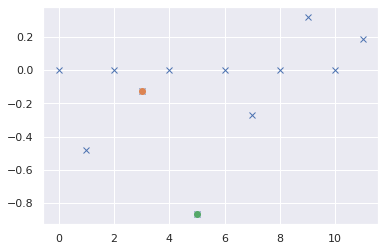

In [56]:
plt.plot(np.arange(12), df_baseline.df[df_baseline.keys['estimator_coeffs']].loc[300], 'x')
plt.plot(3, df_baseline.df[df_baseline.keys['estimator_coeffs'][3]].loc[300], 'o')
plt.plot(5, df_baseline.df[df_baseline.keys['estimator_coeffs'][5]].loc[300], 'o')

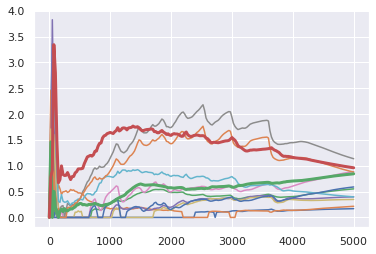

In [68]:
plt.plot(np.abs(df_baseline.df[df_baseline.keys['estimator_coeffs']]))
plt.plot(np.abs(df_baseline.df[df_baseline.keys['estimator_coeffs'][3]]), lw=3)
plt.plot(np.abs(df_baseline.df[df_baseline.keys['estimator_coeffs'][5]]), lw=3)

So it does keep the correct terms... Which is good. With this info, can we try and make it work?

In [ ]:
# Making data
v = 0.1
A = 1.0
x = np.linspace(-5, 5, 100)
t = np.linspace(0.0, 1.0, 50)

x_grid, t_grid = np.meshgrid(x, t, indexing='ij')
dataset = Dataset(DoubleSoliton, c=[5.0, 2.0], x0=[-3.0, -1.0])
X_train, y_train = dataset.create_dataset(x_grid.reshape(-1, 1), t_grid.reshape(-1, 1), n_samples=1000, noise=0.20, normalize=True, random=True)
X_full, y_full = dataset.create_dataset(x_grid.reshape(-1, 1), t_grid.reshape(-1, 1), n_samples=0, noise=0.0, normalize=True, random=False)


# Configuring model
network = Siren(2, [30, 30, 30, 30, 30], 1)
library = Library1D(poly_order=2, diff_order=3) # Library function
estimator = Threshold(0.1) #Clustering() # Sparse estimator 
constraint = LeastSquares() # How to constrain
model = DeepMoD(network, library, estimator, constraint) # Putting it all in the model

# Running model
sparsity_scheduler = Periodic(initial_epoch=300, periodicity=10) # Defining when to apply sparsity
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.99), amsgrad=True) # Defining optimizer

train(model, X_train, y_train, optimizer, sparsity_scheduler, log_dir='data/baseline_working/', write_iterations=25, max_iterations=5000, delta=0.0) # Running

In [79]:
predicted = model(X_full)[0].cpu().detach().numpy().reshape(x_grid.shape)
true = y_full.cpu().detach().numpy().reshape(x_grid.shape)

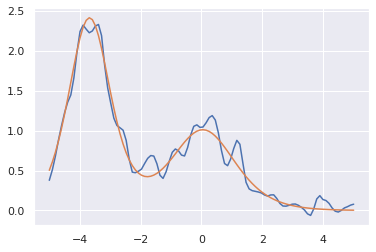

In [80]:
frame = 100
plt.plot(x, predicted[:, 0])
plt.plot(x, true[:, 0])

So it definitely overfits, despite having only a few terms:

In [81]:
model.sparsity_masks

[tensor([False,  True, False, False, False,  True,  True,  True, False, False,
          True,  True])]